In [1]:
import numpy as np
import pandas as pd 
import glob

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm


def setup_mpl():
    """
    Easy setup for matplotlib
    """
    # Change plot
    mpl.rcParams['font.size'] = 16
    # Remove top and right axes
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False
    # No borders in the legend
    mpl.rcParams['legend.frameon'] = False
setup_mpl()

# Define colors
niceblue = "#005b96"
nicered = "#f15152"
nicegreen = "#09814a"
lightblue = "#b3cde0"

# DATA FOLDER
DATA_FOLDER = "./data/"

The tutorial will focus on the paper _Abhijit Banerjee et al. ,The Diffusion of Microfinance. Science 341,1236498 (2013)_. In the paper, the authors explore the diffusion of information on micro-credit in several villages in India. In this tutorial, we will work with the original data from the paper, test some of the authors assumptions, and reproduce some of their results. 

In [2]:
"""
    1. Load data on villages
"""

# Household info
info = pd.read_csv(DATA_FOLDER + "hh-info.csv")
# Leaders-adopters
leadapt = pd.read_csv(DATA_FOLDER + "leaders-adopters.csv")
# Transform villages numbers to make everything coherent
nmap = dict(zip(sorted(leadapt.village.unique()), np.arange(leadapt.village.nunique())))
leadapt["village"] = leadapt.village.map(nmap)
# get two dictionaries
leaders = leadapt.set_index(["village", "hh"]).to_dict()["leader"]
adopters = leadapt.set_index(["village", "hh"]).to_dict()["adopter"]
# Get array mask
leaders_mask = dict()
adopters_mask = dict()
for village in sorted(leadapt.village.unique()):
    leaders_mask[village] = leadapt.loc[leadapt.village == village].leader.values
    adopters_mask[village] = leadapt.loc[leadapt.village == village].adopter.values
# Adjacency_matrix
adjmats = dict()
 
for file in sorted(glob.glob(DATA_FOLDER + "adjmat*.csv")):
    # find key adjmat 1 -> 0
    key = int(file.split("/")[-1].split(".")[0].strip("adjmat")) -1
    # load data as numpy array
    village_adj = np.loadtxt(file, delimiter=",")
    adjmats[key] = village_adj

graphs = dict()
for key, value in adjmats.items():
    village_graph = nx.from_numpy_array(value)
    graphs[key] = village_graph


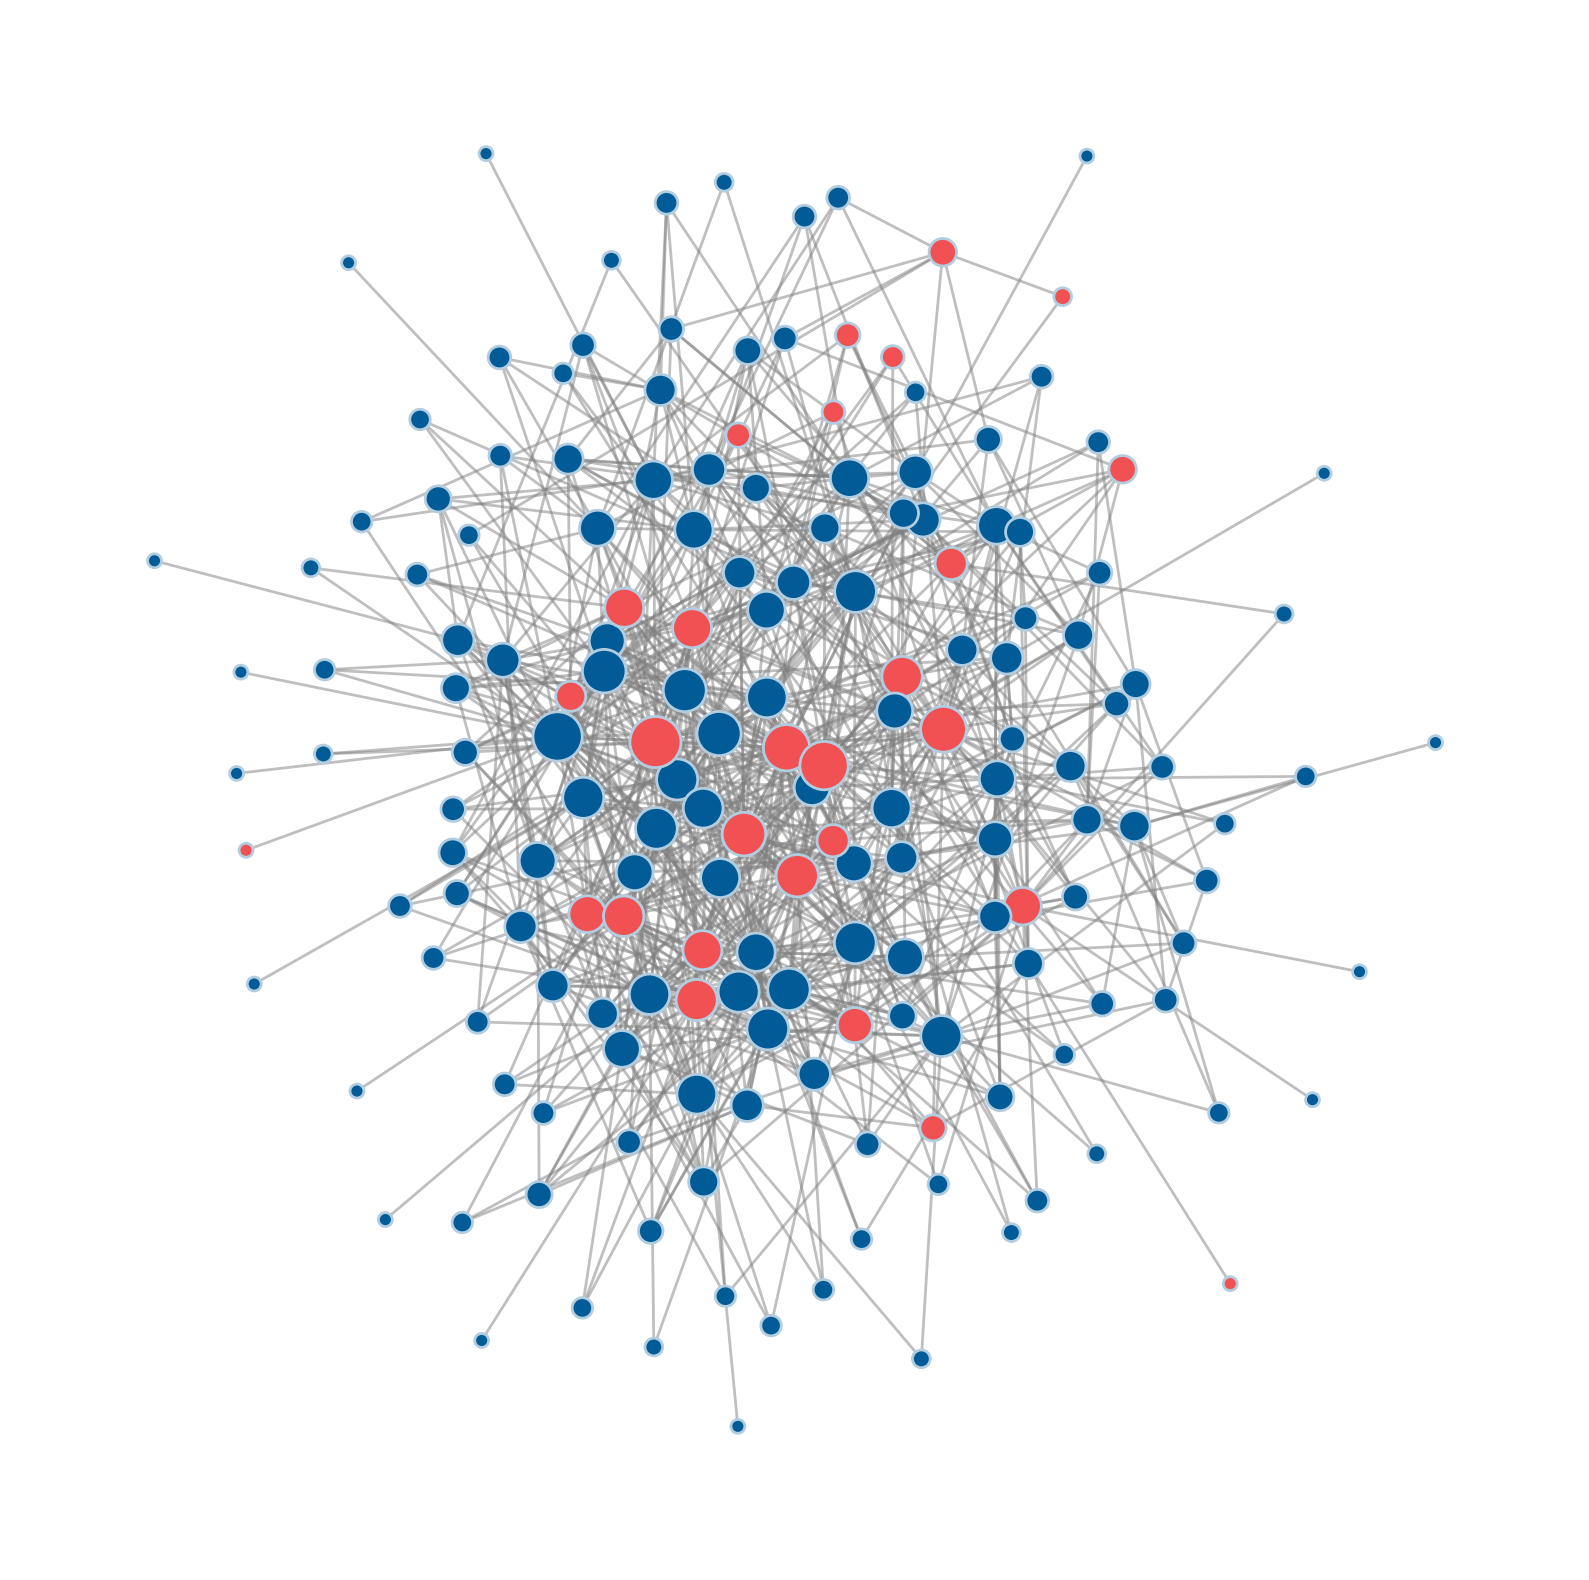

In [3]:
"""
    1.1 Has everything worked? Plot a graph as an example.
"""

fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

# Compute nodes positions using spring layout
pos = nx.kamada_kawai_layout(graphs[0])

# Draw the graph nodes
nx.draw_networkx_nodes(
    graphs[0],
    pos,
    node_size=(adjmats[0].sum(axis=0)*100)**0.7,
    node_color=[niceblue if bool(i) is False else nicered for i in leaders_mask[0]],
    edgecolors=lightblue,
    linewidths=1,
    ax=ax
)

# Draw the graph edges.
nx.draw_networkx_edges(
    graphs[0],
    pos,
    edge_color="gray",
    width=1,
    alpha=0.5,
    ax=ax
)

# remove axis
ax.axis("off")

plt.show()


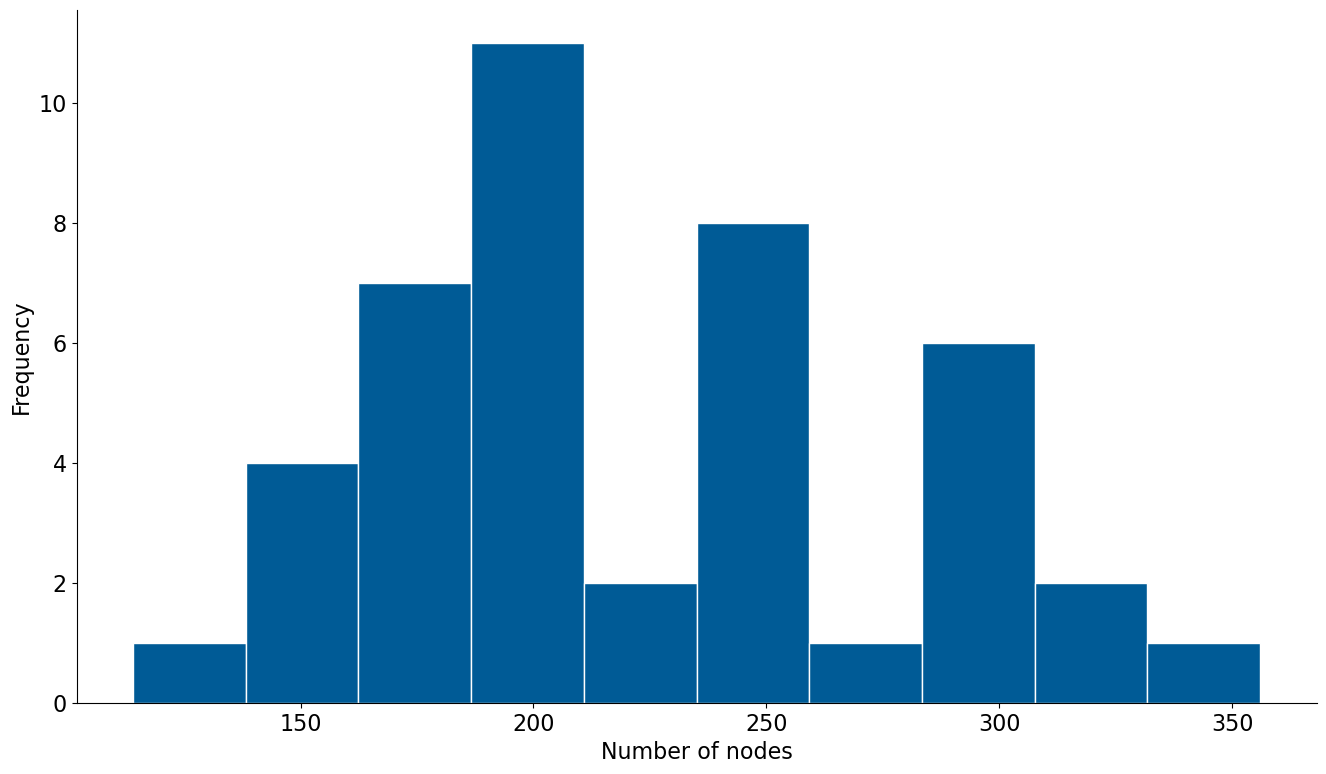

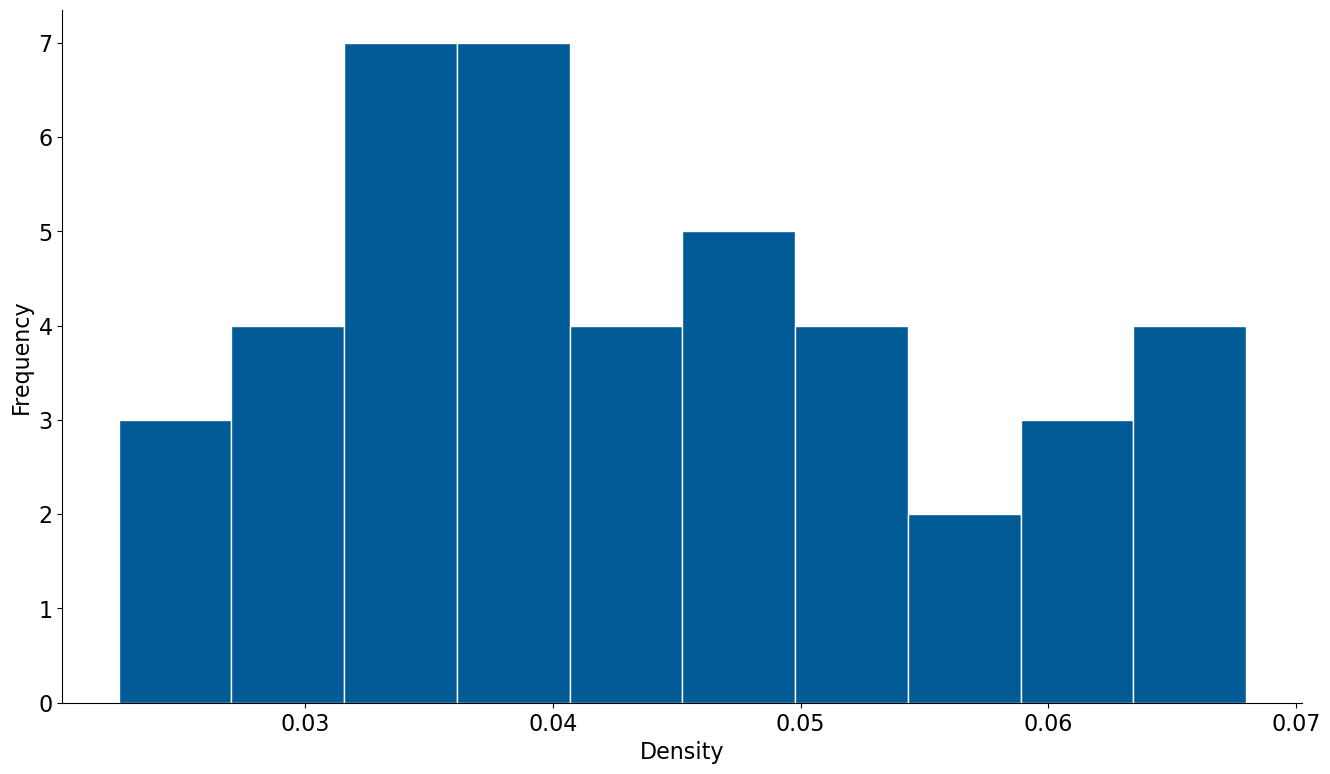

In [4]:
"""
    2. Are the villages similar? 
    Compute and plot a few basic statistics of our networks: number of nodes, number of edges, average degree, density, and number of components.
"""

n_nodes = np.zeros(len(graphs))
n_edges = np.zeros(len(graphs))
avg_degree = np.zeros(len(graphs))
density = np.zeros(len(graphs))
diameter = np.zeros(len(graphs))

for i, graph in graphs.items():
    n_nodes[i] = graph.number_of_nodes()
    n_edges[i] = graph.number_of_edges()
    avg_degree[i] = np.mean([d[1] for d in graph.degree()])
    density[i] = nx.density(graph)
    n_components = nx.number_connected_components(graph)

# Plot distribution of number of nodes
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(n_nodes, bins=10, color=niceblue, edgecolor="white")
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Frequency")
plt.show()

# Plot distribution of density
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(density, bins=10, color=niceblue, edgecolor="white")
ax.set_xlabel("Density")
ax.set_ylabel("Frequency")
plt.show()

In [7]:
"""
    3. BSS, the microfinance institution mentioned in the paper, targeted "leaders" in the villages, assuming that they have a central role in the social network.
    Let's see if this is true.
"""

# Compute degree centrality of leaders in each graph
avg_dc_leaders = np.zeros(len(graphs))
avg_dc_nonleaders = np.zeros(len(graphs))
# Compute betweenness centrality of leaders in each graph
avg_bc_leaders = np.zeros(len(graphs))
avg_bc_nonleaders = np.zeros(len(graphs))
# Compute closeness centrality of leaders in each graph
avg_cc_leaders = np.zeros(len(graphs))
avg_cc_nonleaders = np.zeros(len(graphs))

for i, graph in graphs.items():

    degree_centrality = np.array(list(nx.degree_centrality(graph).values()))
    degree_centrality = degree_centrality / degree_centrality.max()
    avg_dc_leaders[i] = degree_centrality[(leaders_mask[i] == 1)].mean()
    avg_dc_nonleaders[i] = degree_centrality[~(leaders_mask[i] == 1)].mean()
    
    betweenness_centrality = np.array(list(nx.betweenness_centrality(graph).values()))
    betweenness_centrality = betweenness_centrality / betweenness_centrality.max()
    avg_bc_leaders[i] = betweenness_centrality[(leaders_mask[i] == 1)].mean()
    avg_bc_nonleaders[i] = betweenness_centrality[~(leaders_mask[i] == 1)].mean()

    closeness_centrality = np.array(list(nx.closeness_centrality(graph).values()))
    closeness_centrality = closeness_centrality / closeness_centrality.max()
    avg_cc_leaders[i] = closeness_centrality[(leaders_mask[i] == 1)].mean()
    avg_cc_nonleaders[i] = closeness_centrality[~(leaders_mask[i] == 1)].mean()

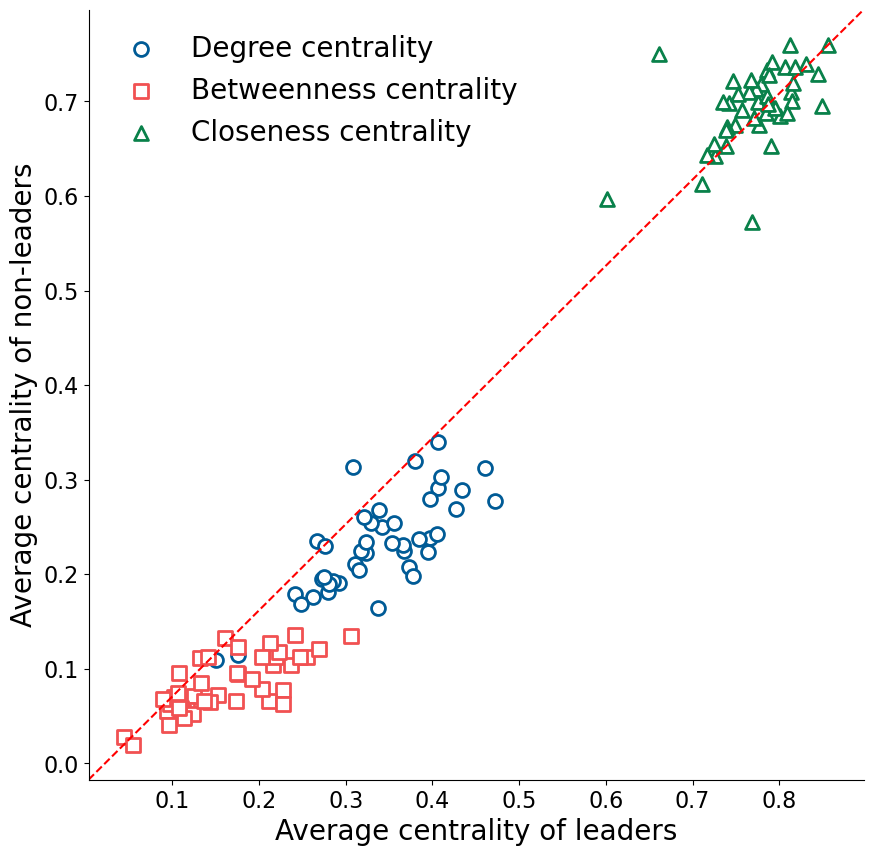

In [8]:
"""
    Plot results
"""
# Make scatterplot of leaders vs non-leaders centrality
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot of degree centrality; blue circles
ax.scatter(
    avg_dc_leaders,
    avg_dc_nonleaders,
    color=niceblue,
    s=100,
    marker="o",
    facecolor="white",
    linewidths=2,
    label="Degree centrality",
)
# Scatter plot of betweenness centrality; red squares
ax.scatter(
    avg_bc_leaders,
    avg_bc_nonleaders,
    color=nicered,
    s=100,
    marker="s",
    facecolor="white",
    linewidths=2,
    label="Betweenness centrality",
)
# Scatter plot of closeness centrality; green triangles
ax.scatter(
    avg_cc_leaders,
    avg_cc_nonleaders,
    color=nicegreen,
    s=100,
    marker="^",
    facecolor="white",
    linewidths=2,
    label="Closeness centrality",
)

# Plot diagonal line
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

# Add legend
ax.legend(loc="upper left", fontsize=20)

# Add labels
ax.set_xlabel("Average centrality of leaders", fontsize=20)
ax.set_ylabel("Average centrality of non-leaders", fontsize=20)

plt.show()

In [ ]:
"""
    4. Assortative/disassortative mixing: do adopters and non-adopters connect more between themselves?
"""

In [ ]:
assortativity = np.zeros(len(graphs))

for i, graph in graphs.items():
    # Select mask
    mask = adopters_mask[i].astype(bool)
    # Get density of connections within adopters
    matrix_index = np.ix_(mask, mask)
    density_adopters = adjmats[i][matrix_index].sum() / adjmats[i].sum()
    # Get density of connections within non-adopters
    matrix_index = np.ix_(~mask, ~mask)
    density_nonadopters = adjmats[i][matrix_index].sum() / adjmats[i].sum()
    # Get density of connections between adopters and non-adopters
    matrix_index = np.ix_(mask, ~mask)
    density_adopters_nonadopters = adjmats[i][matrix_index].sum() / adjmats[i].sum()
    # Compute assortativity
    M = np.zeros((2, 2))
    M[0, 0] = density_adopters
    M[0, 1] = density_adopters_nonadopters
    M[1, 0] = density_adopters_nonadopters
    M[1, 1] = density_nonadopters

    assortativity[i] = (np.trace(M) - np.sum(M ** 2)) / (1 - np.sum(M ** 2))

In [ ]:
# Now let's compute some random benchmarks!
n_iter = 100
assortativity_random = np.zeros((len(graphs), n_iter))
for i, graph in graphs.items():
    # Get adopters mask
    mask = adopters_mask[i].astype(bool)
    # Generate random graphs
    for j in tqdm(range(n_iter), desc="Graph {}".format(i)):
        flag = False
        degree_sequence = adjmats[i].sum(axis=1).astype(int)
        # Check that there are no self loops or multiedges; if so, try again
       
        # Randomize the graph with the configuration model
        graph_random = nx.configuration_model(adjmats[i].sum(axis=1).astype(int))
        # Turn to undirected graph
        graph_random = nx.Graph(graph_random)
        # Remove self loops
        graph_random.remove_edges_from(nx.selfloop_edges(graph_random))
        adj_random = nx.adjacency_matrix(graph_random)
        # Get density of connections within adopters
        matrix_index = np.ix_(mask, mask)
        density_adopters = adj_random[matrix_index].sum() / adj_random.sum()
        # Get density of connections within non-adopters
        matrix_index = np.ix_(~mask, ~mask)
        density_nonadopters = adj_random[matrix_index].sum() / adj_random.sum()
        # Get density of connections between adopters and non-adopters
        matrix_index = np.ix_(mask, ~mask)
        density_adopters_nonadopters = adj_random[matrix_index].sum() / adj_random.sum()
        # Compute assortativity
        M = np.zeros((2, 2))
        M[0, 0] = density_adopters
        M[0, 1] = density_adopters_nonadopters
        M[1, 0] = density_adopters_nonadopters
        M[1, 1] = density_nonadopters

        assortativity_random[i, j] = (np.trace(M) - np.sum(M ** 2)) / (1 - np.sum(M ** 2))
        

In [ ]:
# Plot results

fig, ax = plt.subplots(figsize=(16, 9))
# boxplot plot for the benchmarks. Make the median line red
bp = ax.boxplot(
    assortativity_random.T,
    positions=np.arange(len(graphs)) + 1,
    medianprops={"color": niceblue},
    showfliers=False,
)
# Scatter plot of assortativity
ax.scatter(
    np.arange(len(graphs)) + 1,
    assortativity,
    s=100,
    color=nicered,
    marker="+",
)
plt.show()






In [61]:
"""
    5. (No solution) BSS targeted villages leaders as seed nodes for their diffusion process. Is this a good strategy?
    Simulate the diffusion process using the BSS seed nodes and compare it with a random seed nodes strategy.
    Can you identify better seed nodes?
"""

qN = 0.05
qP = 0.35


def diffusion_InformationModel(village_num, qN, qP, A, seeds, T, leadapt=leadapt):
    """
    Diffusion information model with endorsement. Simpler version of the model in the paper.
    qN: probability of non-infected to transmit the innovation
    qP: probability of infected to transmit the innovation
    A: adjacency matrix
    leaders: boolean array with leaders
    T: number of periods
    """
    N = A.shape[0]  # Number of individuals.
    
    infected = np.zeros(N, dtype=bool)  # Nobody has been infected yet.
    infectedbefore = np.zeros(N, dtype=bool)  # Nobody has been infected yet.
    contagiousbefore = np.zeros(N, dtype=bool)  # People who were contagious before
    contagious = np.array(seeds).astype(bool)  # Newly informed/contagious.
    dynamicInfection = []  # Will be a vector that tracks the infection rate for the number of periods it takes place

    contagious_at_t = np.zeros((T, N), dtype=bool)
    infected_at_t = np.zeros((T, N), dtype=bool)
    
    p = leadapt.loc[leadapt.village == village_num, "adopter"].mean()
    beta = np.log(p / (1 - p))
    
    for t in range(T):

        contagious_at_t[t, :] = contagious.copy()
        infected_at_t[t, :] = infected.copy()

        # Step 1: Take-up decision based on Newly informed, p. 
        LOGITprob = 1. / (1 + np.exp(-beta))
        infected = ((~contagiousbefore & contagious & (np.random.rand(N) < LOGITprob)) | infected)
        infectedbefore = (infectedbefore | infected)
        contagiousbefore = (contagious | contagiousbefore)
        
        # Step 2: Information flows
        transmitPROB = (contagious & infected)*qP + (contagious & ~infected)*qN  # Probability of transmission: Pr(.|infected)==qN, Pr(.|~infected)==qP. Individual (node) specific.
        contagionlikelihood = transmitPROB.reshape(-1, 1)*A
        newcontagious = ((contagionlikelihood > (1. -np.random.random(size=contagionlikelihood.shape))).astype(bool)).any(axis=0)
        
        # Step 3:
        contagious = newcontagious | contagiousbefore
        dynamicInfection.append(np.sum(infectedbefore)/N)
    
    return contagious_at_t, infected_at_t


village_num = 2
contagious_at_t, infected_at_t = diffusion_InformationModel(village_num, qN, qP, adjmats[village_num], leaders_mask[village_num], 20, leadapt=leadapt)

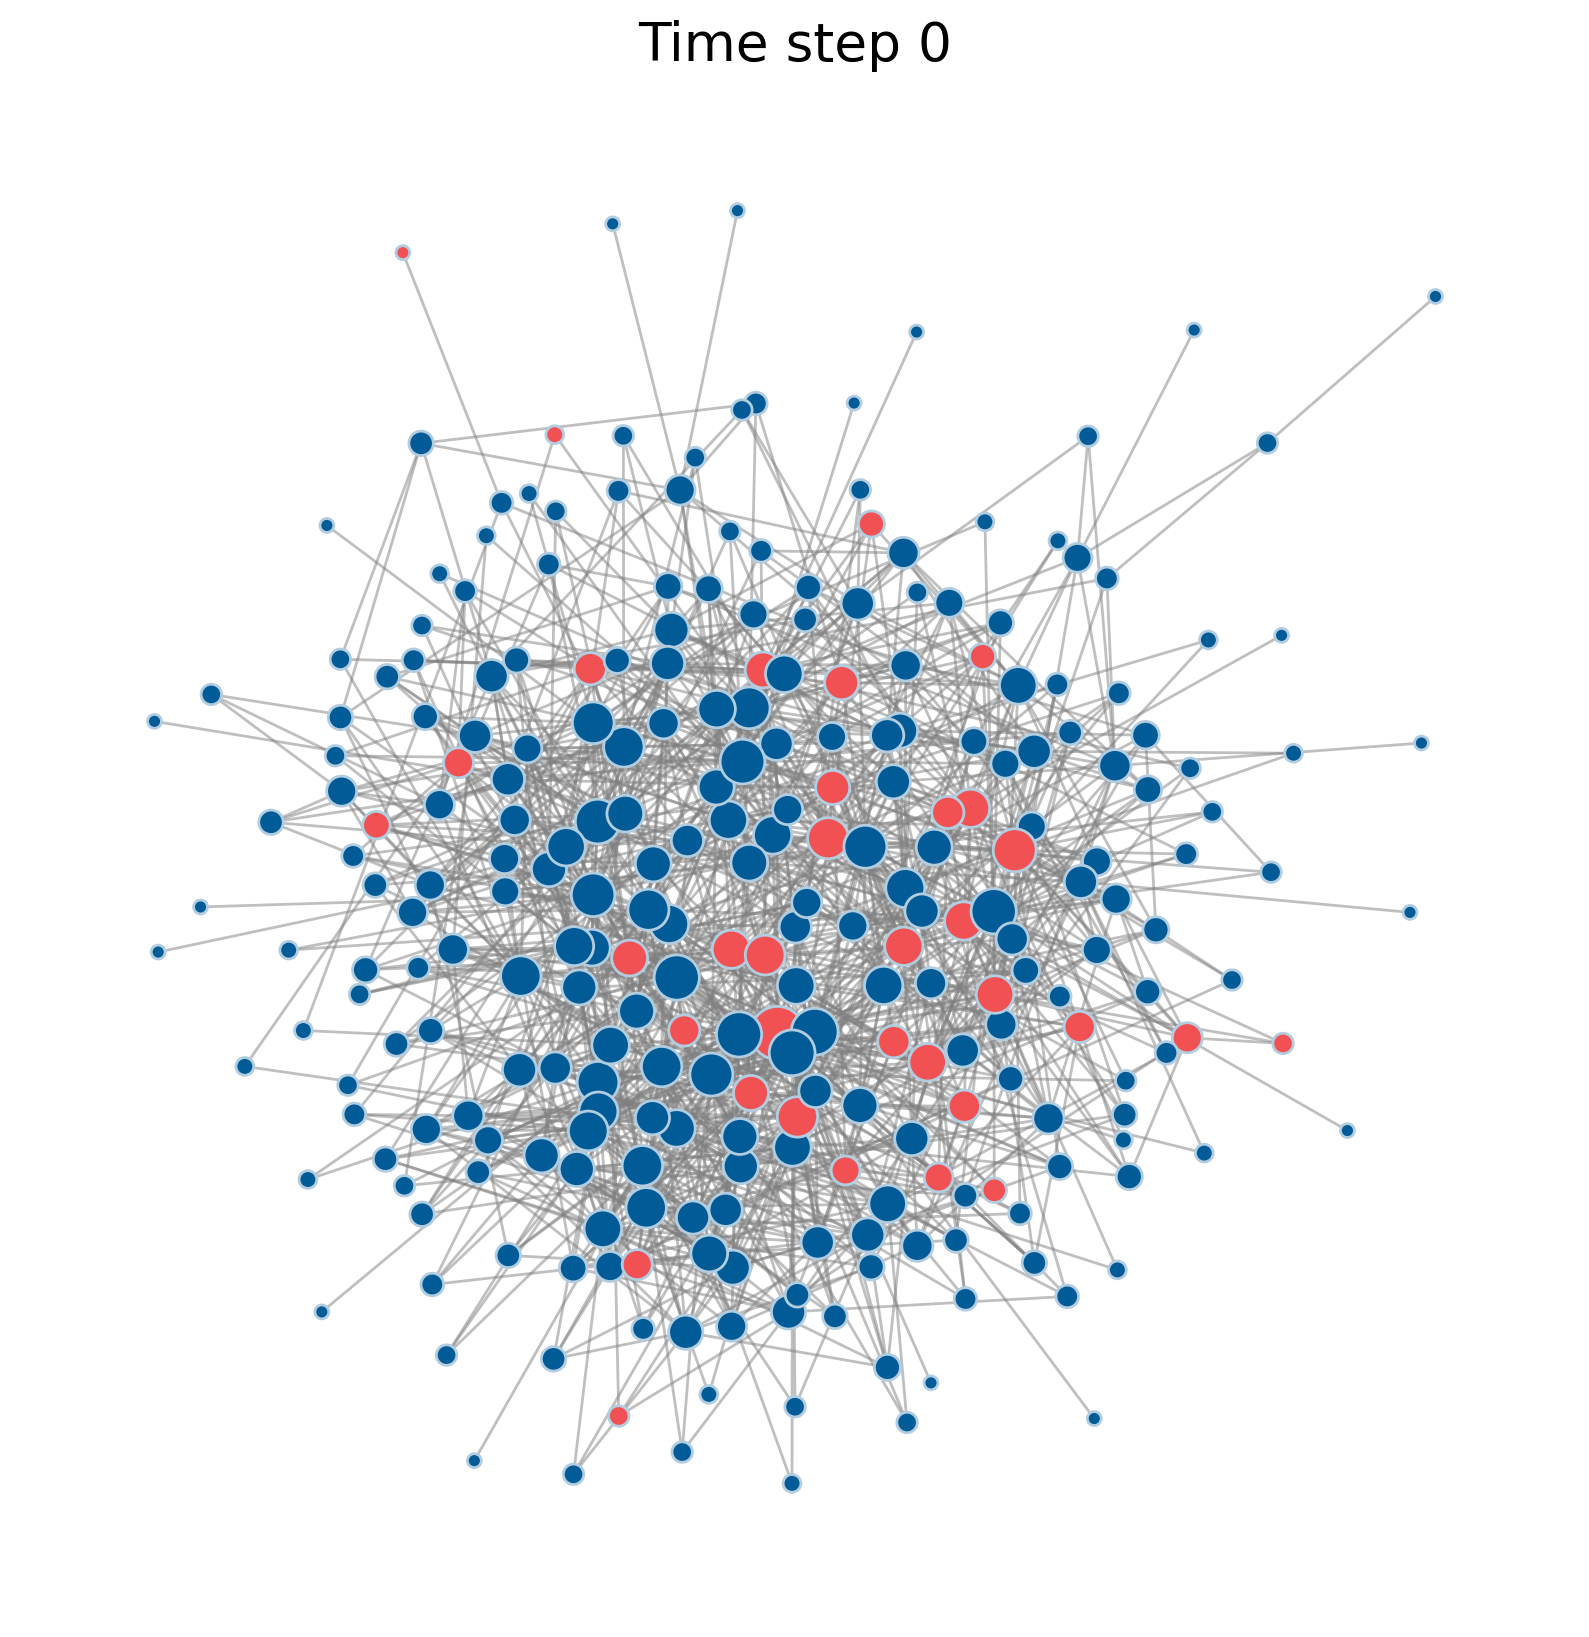

In [64]:
# Make an animation of the diffusion process. Plot the network at each time step and color the nodes according to their state.
# The state is in contagious_at_t
# Import HTML and animation
from IPython.display import HTML
from matplotlib import animation

# Compute nodes positions using spring layout
pos = nx.kamada_kawai_layout(graphs[2])

# Define the function to plot network at time t
def plot_network_t(t, graph_num, adjmats, graphs, pos, contagious_at_t, infected_at_t, ax):
    ax.clear()  # Clear the current plot

    node_color = np.array([niceblue] * len(contagious_at_t[t, :]))
    node_color[contagious_at_t[t, :]] = nicered
    node_color[infected_at_t[t, :]] = nicegreen
    node_color = list(node_color)

    # Draw the graph nodes
    nx.draw_networkx_nodes(
        graphs[graph_num],
        pos,
        node_size=(adjmats[graph_num].sum(axis=0)*100)**0.7,
        node_color=node_color,
        edgecolors=lightblue,
        linewidths=1,
        ax=ax
    )

    # Draw the graph edges.
    nx.draw_networkx_edges(
        graphs[graph_num],
        pos,
        edge_color="gray",
        width=1,
        alpha=0.5,
        ax=ax
    )

    # Remove the axis
    ax.axis("off")
    # Set the title
    ax.set_title("Time step {}".format(t))

# Create a figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

# Create an animation
anim = animation.FuncAnimation(
    fig,
    plot_network_t,
    frames=range(contagious_at_t.shape[0]),
    interval=1000,
    fargs=(2, adjmats, graphs, pos, contagious_at_t, infected_at_t, ax),
)

# Display the animation
HTML(anim.to_html5_video())